# Transfer learning в решении задачи классификации цветов
Датасет классификации цветов (http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) состоит из 102 видов цветов встречаемых в Великобритании. Для каждого класса есть от 40 до 258 примеров, чего мало для обучения с нуля:
<img src="http://bennycheung.github.io/images/deep-transfer-learning-on-small-dataset/flower_train_samples_700.jpg" style="width:50%">

In [2]:
!pip install -q efficientnet

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.io
import tarfile
import csv
import sys
import os


import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import optimizers
import efficientnet.tfkeras as efn

from sklearn.model_selection import train_test_split

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
%matplotlib inline

print(os.listdir(os.getcwd()))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', keras.__version__)

['.vscode', 'best_model.hdf5', 'dataset', 'model_step1.hdf5', 'requirements.txt', 'transfer-learning-keras-flowers-sf-dl-v1.ipynb', 'work']
Python       : 3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


In [2]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
!pip freeze > requirements.txt

# Setup

In [4]:
# В сетап выношу основные настройки, так удобней их перебирать в дальнейшем

EPOCHS               = 5
BATCH_SIZE           = 16 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-3
VAL_SPLIT            = 0.2

CLASS_NUM            = 102
IMG_SIZE             = 250
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = os.path.join(os.getcwd(), 'dataset\\')
PATH = os.path.join(os.getcwd(), 'work\\')

In [5]:
# Setting seed for reproducibility
#os.makedirs(PATH,exist_ok=False)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# Data

In [6]:
# прочитаем все названия файлов прям из архива и таргеты к ним
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]

df = pd.DataFrame()
df['Id'] = sorted(get_all_filenames(DATA_PATH+"102flowers.tgz"))
df['Category'] = scipy.io.loadmat(DATA_PATH+'imagelabels.mat')['labels'][0] - 1  # классы (0, 1, 2, ...)
df['Category'] = df['Category'].astype(str)

In [7]:
df.head(5)

,Id,Category
0,jpg/image_00001.jpg,76
1,jpg/image_00002.jpg,76
2,jpg/image_00003.jpg,76
3,jpg/image_00004.jpg,76
4,jpg/image_00005.jpg,76


In [8]:
df['Category'].value_counts()

50    258
76    251
45    196
72    194
88    184
     ... 
2      40
0      40
26     40
20     40
6      40
Name: Category, Length: 102, dtype: int64

In [9]:
df['Category'].nunique()

102

In [10]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
opened_tar = tarfile.open(DATA_PATH+"102flowers.tgz")
opened_tar.extractall(PATH)

print(os.listdir(PATH+'jpg')[:5])

Распаковываем картинки
['image_00001.jpg', 'image_00002.jpg', 'image_00003.jpg', 'image_00004.jpg', 'image_00005.jpg']


Пример картинок (random sample)


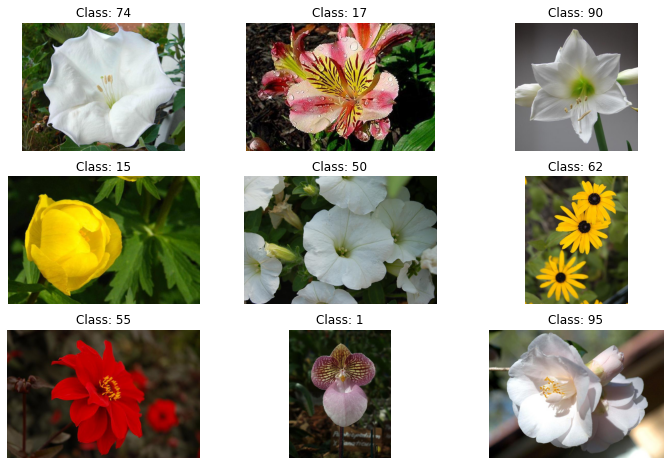

In [11]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+path)
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Пример картинок (random sample)


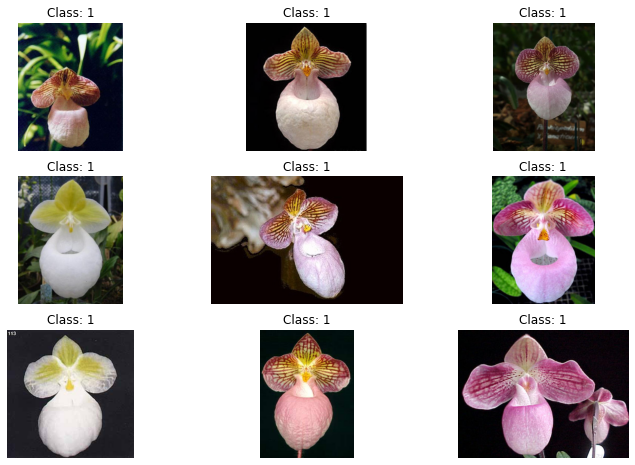

In [12]:
# убедимся что метки классов подгрузились верно
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = df[df['Category']=='1'].sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+path)
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

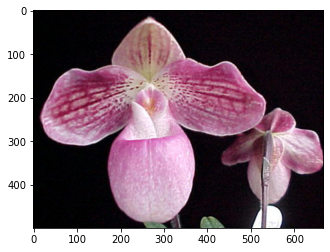

(667, 500)

In [13]:
# как видим изображения имеют разный размер
image = PIL.Image.open(PATH+path)
imgplot = plt.imshow(image)
plt.show()
image.size

 ## Stratify Split

In [14]:
# трейн / тест
train_files, test_files, train_labels, test_labels = \
    train_test_split(df['Id'], df['Category'], test_size=0.2, random_state=42, stratify=df['Category'])

train_files = pd.DataFrame(train_files)
test_files = pd.DataFrame(test_files)
train_files['Category'] = train_labels
test_files['Category'] = test_labels

train_files.shape, test_files.shape

((6551, 2), (1638, 2))

In [15]:
train_files.head(5)

,Id,Category
2361,jpg/image_02362.jpg,42
512,jpg/image_00513.jpg,87
5969,jpg/image_05970.jpg,68
6251,jpg/image_06252.jpg,60
516,jpg/image_00517.jpg,87


In [16]:
train_files['Category'].value_counts()

50    206
76    201
45    157
72    155
88    147
     ... 
33     32
2      32
26     32
20     32
6      32
Name: Category, Length: 102, dtype: int64

In [17]:
test_files['Category'].value_counts()

50    52
76    50
45    39
72    39
88    37
      ..
66     8
2      8
23     8
26     8
0      8
Name: Category, Length: 102, dtype: int64

### Data augmentation

In [18]:
# Аугментация данных очень важна когда у нас не большой датасет (как в нашем случае)

train_datagen = ImageDataGenerator(rescale=1. / 255, 
                                    rotation_range = 50,
                                    shear_range=0.2,
                                    zoom_range=[0.75,1.25],
                                    brightness_range=[0.5, 1.5],
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255)

### datagen

In [19]:
# "Заворачиваем" наши данные в generator

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, 
    seed=RANDOM_SEED,)

Found 6551 validated image filenames belonging to 102 classes.
Found 1638 validated image filenames belonging to 102 classes.


Пример картинок из train_generator


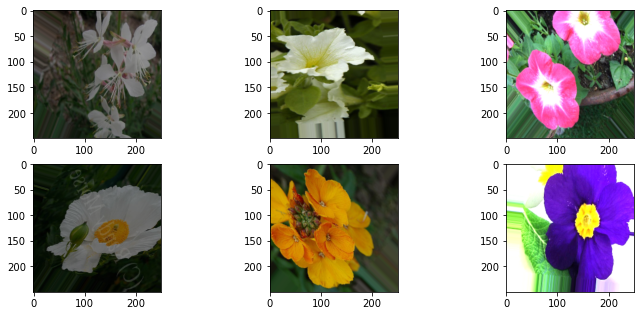

In [20]:
from skimage import io

def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()

x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,6):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

Пример картинок из test_generator


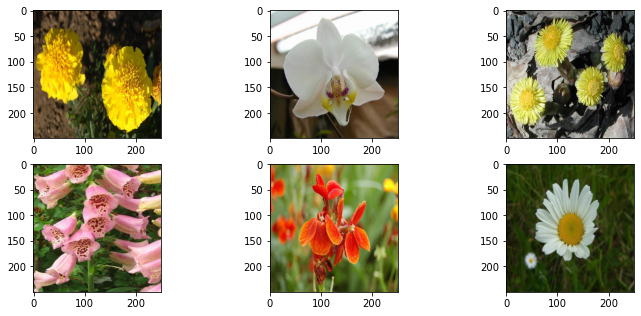

In [21]:
x,y = test_generator.next()
print('Пример картинок из test_generator')
plt.figure(figsize=(12,8))

for i in range(0,6):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

# Model

In [22]:
input_shape

(250, 250, 3)

In [4]:
base_model = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape=input_shape)

NameError: name 'input_shape' is not defined

In [24]:
base_model.summary()

Model: "efficientnet-b6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 125, 125, 56) 1512        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 125, 125, 56) 224         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 125, 125, 56) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [1]:
# first: train only the top layers (which were randomly initialized)
base_model.trainable = False

NameError: name 'base_model' is not defined

In [26]:
model=M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),)
model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Functional) (None, 8, 8, 2304)        40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 102)               235110    
Total params: 41,195,246
Trainable params: 235,110
Non-trainable params: 40,960,136
_________________________________________________________________


In [28]:
# сколько слоев
print(len(model.layers))

3


In [29]:
len(model.trainable_variables)

2

In [30]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x000001F67237A790> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x000001F61E04FA60> True
<tensorflow.python.keras.layers.core.Dense object at 0x000001F62023CDC0> True


## Fit

In [31]:
LR=0.001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [32]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [33]:
scores = model.evaluate(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

103/103 [==============================] - 42s 280ms/step - loss: 4.6660 - accuracy: 0.0107
Accuracy: 1.28%


In [34]:
# Обучаем
history = model.fit_generator(
                    train_generator,
                    steps_per_epoch = train_generator.samples//train_generator.batch_size,
                    validation_data = test_generator, 
                    validation_steps = test_generator.samples//test_generator.batch_size,
                    epochs = 5,
                    callbacks = callbacks_list
                    )

C:\Users\Dimanich\anaconda3\envs\ds\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
Epoch 1/5
  3/409 [..............................] - ETA: 2:40 - loss: 4.5996 - accuracy: 0.0208

In [ ]:
# удивительно на сколько эта модель хорошо умеет извлекать признаки!
# даже без дообучения получаем столь высокий Accuracy

In [ ]:
model.save('model_step1.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

## Step 2

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

In [ ]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
len(base_model.trainable_variables)

In [ ]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

In [ ]:
LR=0.0001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
model.summary()

In [ ]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
# Обучаем
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = 10,
        callbacks = callbacks_list
)

In [ ]:
model.save('../working/model_step2.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
plot_history(history)

## Step 3

In [ ]:
base_model.trainable = True

In [ ]:
LR=0.00001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
# Обучаем
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = 10,
        callbacks = callbacks_list
)

In [ ]:
model.save('../working/model_step3.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

# Step 4

In [ ]:
EPOCHS               = 10
BATCH_SIZE           = 4 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-5

IMG_SIZE             = 512
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255, 
                                    rotation_range = 90,
                                    #shear_range=0.2,
                                    zoom_range=[0.75,1.25],
                                    #brightness_range=[0.5, 1.5],
                                    #width_shift_range=0.1,
                                    #height_shift_range=0.1,
                                    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, 
    seed=RANDOM_SEED,)

In [ ]:
base_model = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape=input_shape)

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
model.load_weights('best_model.hdf5')

In [ ]:
# Обучаем
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

In [ ]:
model.save('../working/model_step4.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
plot_history(history)

# Final Score

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
predictions = model.predict_generator(test_generator, verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir=test_generator.filenames
submission = pd.DataFrame({'Predict':predictions}, columns=['Predict'], index=filenames_with_dir)
test_files.index = test_files['Id']
tmp_y = pd.concat([submission['Predict'], test_files['Category']], axis=1, sort=False)
tmp_y.head(5)

In [ ]:
print('Accuracy: %.2f%%' % (accuracy_score(tmp_y['Category'], tmp_y['Predict'],)*100))

# TTA

In [ ]:
model.load_weights('best_model.hdf5')

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255,
                                 rotation_range = 90,
                                    shear_range=0.2,
                                    zoom_range=[0.75,1.25],
                                    brightness_range=[0.5, 1.5],
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,)

In [ ]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, 
    seed=RANDOM_SEED,)

In [ ]:
x,y = test_generator.next()
print('Пример картинок из test_generator')
plt.figure(figsize=(12,8))

for i in range(0,6):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
plt.show()

In [ ]:
tta_steps = 10
predictions = []

for i in range(tta_steps):
    preds = model.predict_generator(test_generator, verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

In [ ]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]
filenames_with_dir=test_generator.filenames
submission = pd.DataFrame({'Predict':predictions}, columns=['Predict'], index=filenames_with_dir)
tmp_y = pd.concat([submission['Predict'], test_files['Category']], axis=1, sort=False)

In [ ]:
print('Accuracy: %.2f%%' % (accuracy_score(tmp_y['Category'], tmp_y['Predict'],)*100))

## clean

In [ ]:
# Clean PATH
import shutil
shutil.rmtree(PATH)